In [1]:
import numpy as np

import os
import mccd
from astropy.io import fits
import galsim as gs
import mccd.mccd_utils as mccd_utils
import mccd.utils as utils
import scipy as sp

import gc
from configparser import ConfigParser


import random

import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap, LinearSegmentedColormap



INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


## Define the class to generate a dataset based on new functions defining the ellipticities variations 

In [2]:
def poly_pos(pos, max_degree, center_normalice=True,
             x_lims = None, y_lims = None):
    r"""Construct polynomial matrix.
    Return a matrix Pi containing polynomials of stars
    positions up to ``max_degree``.
    Defaulting to CFIS CCD limits.
    New method:
    The positions are scaled to the [-0.5, 0.5]x[-0.5, 0.5].
    Then the polynomials are constructed with the normalized positions.
    Old method:
    Positions are centred, the polynomials are constructed.
    Then the polynomials are normalized.
    """
    n_mono = (max_degree + 1) * (max_degree + 2) // 2
    Pi = np.zeros((n_mono, pos.shape[0]))
    _pos = np.copy(pos)
    if x_lims is None:
        x_min = np.min(_pos[:, 0])
        x_max = np.max(_pos[:, 0])
        x_lims = [x_min, x_max]
        # print('x_lims: ', x_lims)
    if y_lims is None:
        y_min = np.min(_pos[:, 1])
        y_max = np.max(_pos[:, 1])
        y_lims = [y_min, y_max]
        # print('y_lims: ', y_lims)
    if center_normalice:
        _pos[:, 0] = (_pos[:, 0] - x_lims[0])/(x_lims[1] - x_lims[0]) - 1/2
        _pos[:, 1] = (_pos[:, 1] - y_lims[0])/(y_lims[1] - y_lims[0]) - 1/2
    # print('min_x = ', np.min(_pos[:, 0]))     
    # print('max_x = ', np.max(_pos[:, 0]))
    # print('min_y = ', np.min(_pos[:, 1])) 
    # print('max_y = ', np.max(_pos[:, 1]))
    for d in range(max_degree + 1):
        row_idx = d * (d + 1) // 2
        for p in range(d + 1):
            Pi[row_idx + p, :] = _pos[:, 0] ** (d - p) * _pos[:, 1] ** p
    return Pi

In [12]:
class GenerateSimDataset(object):
    r"""Generate simulated dataset for training and validating PSF models.
    Parameters
    ----------
    input_pos_path: str
        Path to the global positions of the PSF that will be used for the
        training.
    input_ccd_path: str
        Path to the corresponding CCDs of the global positions.
    output_path: str
        Path to the folder to save the simulated datasets.
    e1_analytic_fun: function
        The analytic e1 ellipticity function that will define an ellipticity
        e1 for each position in the focal plane.
    e2_analytic_fun: function
        The analytic e2 ellipticity function that will define an ellipticity
        e2 for each position in the focal plane.
    Notes
    -----
    The simulated PSFs are based on the Moffat profile and we are using Galsim
    to generate them.
    We base ourselves on two analytic functions that have to output an
    ellipticity for each position in the focal plane.
    """

    def __init__(self, output_path,
                 e1_analytic_fun=None, e2_analytic_fun=None, poly_id=19):
        r"""Initialize the class."""
        self.output_path = output_path
        self.e1_analytic_fun = e1_analytic_fun
        self.e2_analytic_fun = e2_analytic_fun
        
        self.poly_dict = np.load('./dict/params_' + str(poly_id)
                            + '.npy', allow_pickle=True).item()        
        
        loc2glob = mccd.mccd_utils.Loc2Glob()    
        self.max_x = loc2glob.x_npix*6 + loc2glob.x_gap*5
        self.min_x = loc2glob.x_npix*(-5) + loc2glob.x_gap*(-5)
        self.max_y = loc2glob.y_npix*2 + loc2glob.y_gap*1
        self.min_y = loc2glob.y_npix*(-2) + loc2glob.y_gap*(-2)

        self.positions = None
        self.ccd_id = None

        # Train/Test data params
        self.sigma = None
        self.image_size = None
        self.psf_flux = None
        self.beta_psf = None
        self.pix_scale = None
        self.desired_SNR = None
        self.catalog_id = None
        self.test_grid_xy = None
        self.n_ccd = None

        if e1_analytic_fun is None:
            self.e1_analytic_fun = self.e1_catalog_fun
        if e2_analytic_fun is None:
            self.e2_analytic_fun = self.e2_catalog_fun

    def load_data(self):
        r"""Load data from input paths."""
        positions = np.zeros((2400,2))
        ccd_list = np.zeros(2400)
        for i in range (2400):
            ccd = np.floor((i/60))
            x = np.random.uniform(0,2048)
            y = np.random.uniform(0,4612)
            positions[i] = loc2glob.loc2glob_img_coord(ccd_n=ccd,x_coor=x,y_coor=y)
            ccd_list[i] = ccd
        try:
            self.positions = positions
            self.ccd_id = ccd_list
        except FileNotFoundError:
            print('The positions or ccd path was not found. Check the paths.')
            raise FileNotFoundError

    def generate_train_data(self, sigma=1.6, image_size=51, psf_flux=1.,
                            beta_psf=4.8, pix_scale=0.187,
                            desired_SNR=30, catalog_id=2086592):
        r"""Generate the training dataset and saves it in fits format.
        Parameters
        ----------
        sigma: float
            Size of the PSF in sigma's. (Sigma from Galsim's HSM adaptive
            moments).
            Default is ``1.6``.
        image_size: int
            Dimension of the squared image stamp. (image_size x image_size)
            Default is ``51``.
        psf_flux: float
            Total PSF photometric flux.
            Default is ``1``.
        beta_psf: float
            Moffat beta parameter.
            Default is ``4.8``.
        pix_scale: float
            Pixel scale.
            Default is ``0.187``.
        desired_SNR: float
            Desired SNR
            Default is ``30``.
        catalog_id: int
            Catalog identifier number.
            Default is ``2086592``.
        """
        # Parameters
        self.sigma = sigma
        self.image_size = image_size
        self.psf_flux = psf_flux
        self.beta_psf = beta_psf
        self.pix_scale = pix_scale
        self.desired_SNR = desired_SNR
        self.catalog_id = catalog_id

        # Define the ellipticities for each stars
        e1s = np.array(
            [self.e1_catalog_fun(position[0], position[1]) for position in
             self.positions])
        e2s = np.array(
            [self.e2_catalog_fun(position[0], position[1]) for position in
             self.positions])
        r2s = np.array(
            [self.r2_catalog_fun(position[0], position[1]) for position in
             self.positions])

        # Define the constant shape of the stars (before the shearing)
        sigma_vect = np.sqrt(r2s/2)
        fwhms = (2 * np.sqrt(2 * np.log(2))) * sigma_vect # Around 4. and 6. in sigma
        
        # Generate the vignets
        new_vignets = np.zeros((e1s.shape[0], image_size, image_size))
        new_e1_HSM = np.zeros(e1s.shape)
        new_e2_HSM = np.zeros(e1s.shape)
        new_sig_HSM = np.zeros(e1s.shape)
        d_snr = np.linspace(10,100, 10)
        d_snr = np.repeat(d_snr, 240)
        np.random.shuffle(d_snr)
        for it in range(e1s.shape[0]):
            # PSF generation. Define size
            psf = gs.Moffat(fwhm=fwhms[it] * pix_scale, beta=beta_psf)

            # Define the Flux
            psf = psf.withFlux(psf_flux)
            # Define the shear
            psf = psf.shear(g1=e1s[it], g2=e2s[it])
            # Draw the PSF on a vignet
            noisy_image_epsf = gs.ImageF(image_size, image_size)
            # Define intrapixel shift (uniform distribution in [-0.5,0.5])
            rand_shift = np.random.rand(2) - 0.5
            psf.drawImage(image=noisy_image_epsf, offset=rand_shift,
                          scale=pix_scale)
            
            

            sigma_noise = np.sqrt((np.sum(noisy_image_epsf.array ** 2)) / (
                    d_snr[it] * image_size ** 2))
            
            # Generate Gaussian noise for the PSF
            gaussian_noise = gs.GaussianNoise(sigma=sigma_noise)

            # Before adding the noise, we measure the ellipticity components
            my_moments = gs.hsm.FindAdaptiveMom(noisy_image_epsf)
            new_e1_HSM[it] = my_moments.observed_shape.g1
            new_e2_HSM[it] = my_moments.observed_shape.g2
            new_sig_HSM[it] = my_moments.moments_sigma

            # Add Gaussian noise to the PSF
            noisy_image_epsf.addNoise(gaussian_noise)

            new_vignets[it, :, :] = noisy_image_epsf.array

        new_masks = self.handle_SExtractor_mask(new_vignets, thresh=-1e5)

        # Build the dictionary
        train_dic = {'VIGNET_LIST': new_vignets,
                     'GLOB_POSITION_IMG_LIST': self.positions,
                     'MASK_LIST': new_masks, 'CCD_ID_LIST': self.ccd_id,
                     'TRUE_E1_HSM': new_e1_HSM, 'TRUE_E2_HSM': new_e2_HSM,
                     'TRUE_SIG_HSM': new_sig_HSM}

        # Save the fits file
        mccd_utils.save_fits(train_dic, train_bool=True, cat_id=catalog_id,
                             output_path=self.output_path)

    def generate_test_data(self, x_grid=5, y_grid=10, n_ccd=40):
        r"""Generate the test dataset and save it into a fits file.
        Parameters
        ----------
        x_grid: int
            Horizontal number of elements of the testing grid in one CCD.
        y_grid: int
            Vertical number of elements of the testing grid in one CCD.
        n_ccd: int
            Number of CCDs in the instrument.
        Notes
        -----
        ``n_ccd`` should be coherent with the corresponding functions on
        ``mccd.mccd_utils`` that do the change of coordiante system.
        """
        # Parameters
        self.test_grid_xy = [x_grid,
                             y_grid]  # Grid size for the PSF generation
        self.n_ccd = n_ccd

        # Generation of the test positions
        ccd_unique_list = np.arange(self.n_ccd)

        # Saving file dictionary
        loc2glob = mccd_utils.Loc2Glob()

        # Generate local generic grid
        x_lin = np.linspace(start=self.image_size,
                            stop=loc2glob.x_npix - self.image_size,
                            num=self.test_grid_xy[0])
        y_lin = np.linspace(start=self.image_size,
                            stop=loc2glob.y_npix - self.image_size,
                            num=self.test_grid_xy[1])
        xv, yv = np.meshgrid(x_lin, y_lin)
        x_coor = xv.flatten()
        y_coor = yv.flatten()

        position_list = []
        ccd_list = []

        for it in range(len(ccd_unique_list)):
            x_glob, y_glob = loc2glob.loc2glob_img_coord(
                ccd_n=ccd_unique_list[it],
                x_coor=np.copy(x_coor), y_coor=np.copy(y_coor))
            position_list.append(np.array([x_glob, y_glob]).T)
            ccd_list.append(
                (np.ones(len(x_glob), dtype=int) * ccd_unique_list[it]).astype(
                    int))

        # Obtain final positions and ccd_id list
        test_positions = np.concatenate(position_list, axis=0)
        test_ccd_id = np.concatenate(ccd_list, axis=0)

        # Calculate the ellipticities on the testing positions
        test_e1s = np.array(
            [self.e1_catalog_fun(position[0], position[1]) for position in
             test_positions])
        test_e2s = np.array(
            [self.e2_catalog_fun(position[0], position[1]) for position in
             test_positions])
        test_r2s = np.array(
            [self.r2_catalog_fun(position[0], position[1]) for position in
             self.positions])

        # Define the constant shape of the stars (before the shearing)
        sigma_vect = np.sqrt(test_r2s/2)
        test_fwhms = (2 * np.sqrt(2 * np.log(2))) * sigma_vect # Around 4. and 6. in sigma

        # Generate the vignets
        test_vignets = np.zeros(
            (test_e1s.shape[0], self.image_size, self.image_size))
        test_e1_HSM = np.zeros(test_e1s.shape)
        test_e2_HSM = np.zeros(test_e1s.shape)
        test_sig_HSM = np.zeros(test_e1s.shape)
        for it in range(test_e1s.shape[0]):
            # PSF generation. Define size
            psf = gs.Moffat(fwhm=test_fwhms[it] * self.pix_scale,
                            beta=self.beta_psf)
            # Define the Flux
            psf = psf.withFlux(self.psf_flux)
            # Define the shear
            psf = psf.shear(g1=test_e1s[it], g2=test_e2s[it])
            # Draw the PSF on a vignet
            image_epsf = gs.ImageF(self.image_size, self.image_size)
            psf.drawImage(image=image_epsf, scale=self.pix_scale)

            # Before adding the noise, we measure the ellipticity components
            my_moments = gs.hsm.FindAdaptiveMom(image_epsf)
            test_e1_HSM[it] = my_moments.observed_shape.g1
            test_e2_HSM[it] = my_moments.observed_shape.g2
            test_sig_HSM[it] = my_moments.moments_sigma

            test_vignets[it, :, :] = image_epsf.array

        # Build the masks
        test_masks = self.handle_SExtractor_mask(test_vignets, thresh=-1e5)

        # Build the dictionary
        test_dic = {'VIGNET_LIST': test_vignets,
                    'GLOB_POSITION_IMG_LIST': test_positions,
                    'MASK_LIST': test_masks, 'CCD_ID_LIST': test_ccd_id,
                    'TRUE_E1_HSM': test_e1_HSM, 'TRUE_E2_HSM': test_e2_HSM,
                    'TRUE_SIG_HSM': test_sig_HSM}

        # Save the fits file
        mccd_utils.save_fits(test_dic, train_bool=False,
                             cat_id=self.catalog_id,
                             output_path=self.output_path)

    def poly_pos(self, pos, max_degree, center_normalice=True,
             x_lims = None, y_lims = None):
        r"""Construct polynomial matrix.
        Return a matrix Pi containing polynomials of stars
        positions up to ``max_degree``.
        Defaulting to CFIS CCD limits.
        New method:
        The positions are scaled to the [-0.5, 0.5]x[-0.5, 0.5].
        Then the polynomials are constructed with the normalized positions.
        Old method:
        Positions are centred, the polynomials are constructed.
        Then the polynomials are normalized.
        """
        n_mono = (max_degree + 1) * (max_degree + 2) // 2
        Pi = np.zeros((n_mono, pos.shape[0]))
        _pos = np.copy(pos)
        if x_lims is None:
            x_min = np.min(_pos[:, 0])
            x_max = np.max(_pos[:, 0])
            x_lims = [x_min, x_max]
            # print('x_lims: ', x_lims)
        if y_lims is None:
            y_min = np.min(_pos[:, 1])
            y_max = np.max(_pos[:, 1])
            y_lims = [y_min, y_max]
            # print('y_lims: ', y_lims)
        if center_normalice:
            _pos[:, 0] = (_pos[:, 0] - x_lims[0])/(x_lims[1] - x_lims[0]) - 1/2
            _pos[:, 1] = (_pos[:, 1] - y_lims[0])/(y_lims[1] - y_lims[0]) - 1/2
        # print('min_x = ', np.min(_pos[:, 0]))     
        # print('max_x = ', np.max(_pos[:, 0]))
        # print('min_y = ', np.min(_pos[:, 1])) 
        # print('max_y = ', np.max(_pos[:, 1]))
        for d in range(max_degree + 1):
            row_idx = d * (d + 1) // 2
            for p in range(d + 1):
                Pi[row_idx + p, :] = _pos[:, 0] ** (d - p) * _pos[:, 1] ** p
        return Pi

    
    def e1_catalog_fun(self, x, y):
        r"""Define an e1 ellipticity per position.
        Analytic function for defining the e1 ellipticity as a function
        of the global position (MegaCam).
        """
        
        # Create a position vector and extract the features
        
        vect_pos = np.array([[float(x),float(y)]])
        features = self.poly_pos(vect_pos, 4, x_lims=[self.min_x, self.max_x], y_lims=[self.min_y, self.max_y])
        
        # Calculate the polynomial function of the positions
        
        e1 = np.matmul(self.poly_dict['coeffs_e1'], features)
        
        # Scale the results
        
        e1 = (e1 - self.poly_dict['min_e1'])/(self.poly_dict['max_e1'] - self.poly_dict['min_e1'])-1/2

        return e1*2*self.poly_dict['lim_e1']


    def e2_catalog_fun(self, x, y):
        r"""Define an e2 ellipticity per position.
        Analytic function for defining the e2 ellipticity as a function
        of the global position (MegaCam).
        """
        # Create a position vector and extract the features
        
        vect_pos = np.array([[float(x),float(y)]])
        features = self.poly_pos(vect_pos, 4, x_lims=[self.min_x, self.max_x], y_lims=[self.min_y, self.max_y])
        
        # Calculate the polynomial function of the positions
        
        e2 = np.matmul(self.poly_dict['coeffs_e2'], features)
        
        # Scale the results
        
        e2 = (e2 - self.poly_dict['min_e2'])/(self.poly_dict['max_e2'] - self.poly_dict['min_e2'])-1/2

        return e2*2*self.poly_dict['lim_e2']
    
    
    def r2_catalog_fun(self, x, y):
        
        # Create a position vector and extract the features
        
        vect_pos = np.array([[float(x),float(y)]])
        features = self.poly_pos(vect_pos, 4, x_lims=[self.min_x, self.max_x], y_lims=[self.min_y, self.max_y])
        
        # Calculate the polynomial function of the positions
        
        r2 = np.matmul(self.poly_dict['coeffs_r2'], features)
        
        # Scale the results
        
        r2 = (r2 - self.poly_dict['min_r2'])/((self.poly_dict['max_r2'] - self.poly_dict['min_r2']))+3.5
        
        return r2
        

    @staticmethod
    def scale_coordinates(x, y, coor_min, coor_max, offset=None):
        r"""Scale global coordinates."""
        # Set the max and min values for the coordinate system
        loc2glob = mccd_utils.Loc2Glob()
        grid_xmin = - 5 * loc2glob.x_npix - 5 * loc2glob.x_gap
        grid_xmax = 6 * loc2glob.x_npix + 5 * loc2glob.x_gap
        grid_ymin = -2 * loc2glob.y_npix - 2 * loc2glob.y_gap
        grid_ymax = 2 * loc2glob.y_npix + 1 * loc2glob.y_gap

        # Scale the input coordinates
        scaled_x = ((x - grid_xmin) / (grid_xmax - grid_xmin)) * (
                coor_max - coor_min) + coor_min
        scaled_y = ((y - grid_ymin) / (grid_ymax - grid_ymin)) * (
                coor_max - coor_min) + coor_min

        if offset is not None:
            scaled_x += offset[0]
            scaled_y += offset[1]

        return scaled_x, scaled_y


    @staticmethod
    def handle_SExtractor_mask(stars, thresh):
        r"""Handle SExtractor masks.
        Reads SExtracted star stamps, generates MCCD-compatible masks
        (that is, binary weights), and replaces bad pixels with 0s - they will
        not be used by MCCD, but the ridiculous numerical values can
        otherwise still lead to problems because of convolutions.
        """
        mask = np.ones(stars.shape)
        mask[stars < thresh] = 0
        stars[stars < thresh] = 0
        return mask

In [13]:
loc2glob = mccd.mccd_utils.Loc2Glob()

plt.rc('text', usetex=True)
font = {'family' : 'serif',
        'weight' : 'bold',
        'size'   : 20}
mpl.rc('font', **font)

plot_style = {
                'figure.figsize': (6,6),
                'figure.dpi': 100,
                'figure.autolayout':True,
                'lines.linewidth': 4,
                'lines.linestyle': '-',
                'lines.marker': 'o',
                'lines.markersize': 10,
                'legend.fontsize': 20,
                'legend.loc': 'best',
                'axes.titlesize': 24,
                'axes.grid': False,
                'axes.grid.which': 'major',
                'axes.grid.axis': 'both'}
mpl.rcParams.update(plot_style)

# Pre-defined colormap
top = mpl.cm.get_cmap('Oranges_r', 128)
bottom = mpl.cm.get_cmap('Blues', 128)
newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))
newcmp = ListedColormap(newcolors, name='OrangeBlue')


def plot_ccds_fun(positions,mom,title):
    fig = plt.figure(figsize=(8, 8))
    ax1 = fig.add_subplot(111)
    for ccd_it in range(40):
        xs,ys = loc2glob.shift_coord(ccd_it)
        rect = mpl.patches.Rectangle((xs,ys),2048,4612,linewidth=1,edgecolor='r',facecolor='none')
        ax1.add_patch(rect)

    im1 = ax1.scatter(positions[:, 0], positions[:, 1], s=5,c=mom, marker='*', cmap=newcmp)
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im1, cax=cax, orientation='vertical')
    ax1.set_xticks([]);ax1.set_yticks([])
    ax1.axis('off')
    ax1.set_title(title)
    plt.show()

In [14]:
# input_pos_path = './data/sim_inputs/train_positions.npy'
# input_ccd_path = './data/sim_inputs/train_ccd_list.npy'
output_path = './data/test_poly/'

## Testing generating one stars catalog based on one fixed catalog of polynomial variations

In [15]:
poly_id = 14
catalog_id = '200000' + str(poly_id)
catalog_id = int(catalog_id)

sim_dataset_generator = GenerateSimDataset(output_path, poly_id=poly_id)
sim_dataset_generator.load_data()
sim_dataset_generator.generate_train_data(catalog_id=catalog_id)
sim_dataset_generator.generate_test_data(x_grid=5, y_grid=10)

ext = '.fits'
catalog_id = catalog_id

train_cat_path = output_path + 'train_star_selection-' + str(catalog_id) + ext
test_cat_path = output_path + 'test_star_selection-' + str(catalog_id) + ext



In [16]:
train_cat = fits.open(train_cat_path)[1]

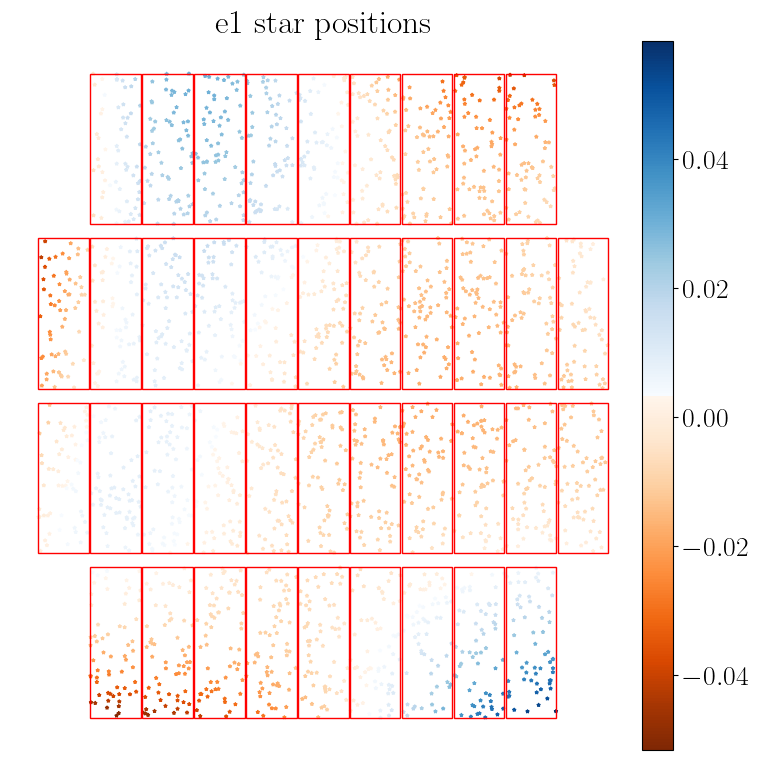

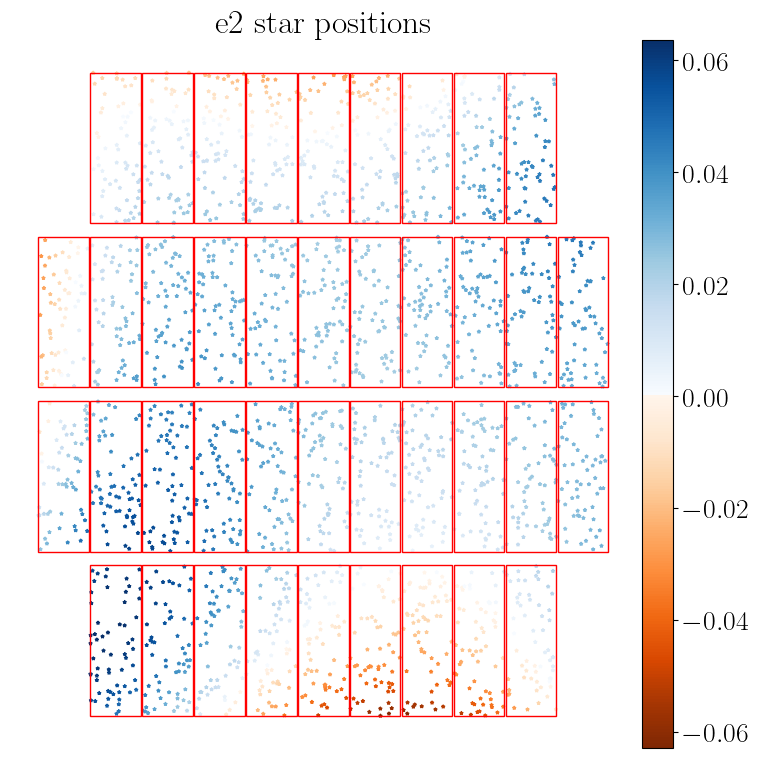

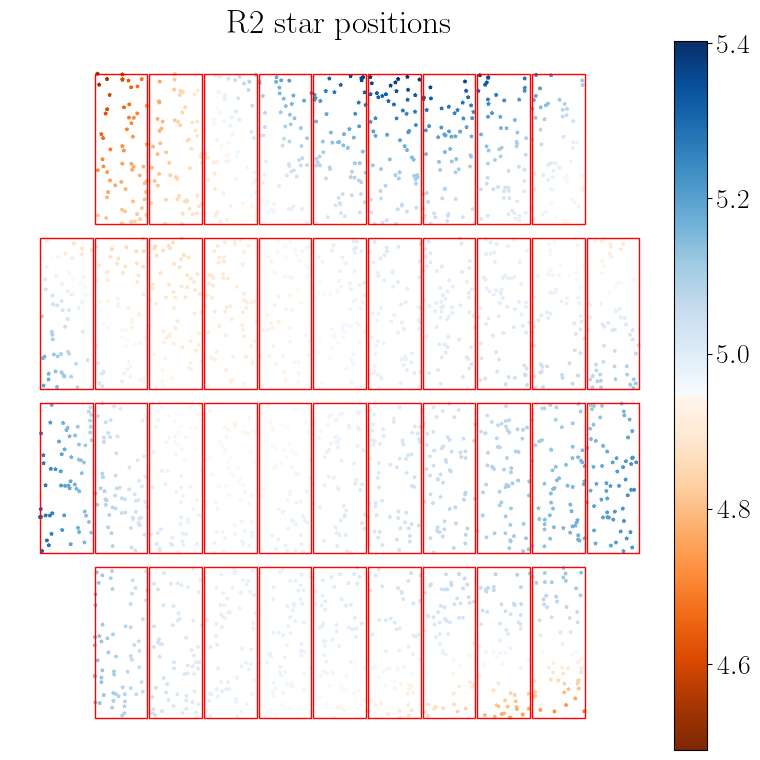

In [17]:
pos = train_cat.data['GLOB_POSITION_IMG_LIST']
plot_ccds_fun(pos,train_cat.data['TRUE_E1_HSM'],'e1 star positions')
plot_ccds_fun(pos,train_cat.data['TRUE_E2_HSM'],'e2 star positions')
plot_ccds_fun(pos,2.*train_cat.data['TRUE_SIG_HSM']**2,'R2 star positions')

In [18]:
# Load the data
train_cat = fits.open(train_cat_path)
train_cat[1].columns

stars = np.copy(train_cat[1].data['VIGNET_LIST'])

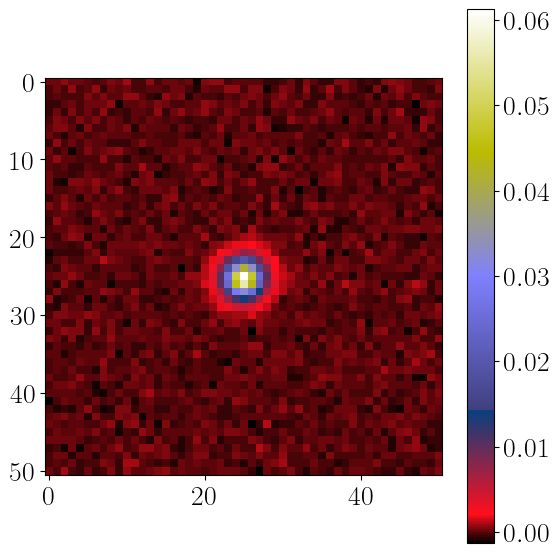

In [19]:
ind=2000
plt.imshow(stars[ind], interpolation='None',cmap='gist_stern');plt.colorbar()